In [14]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import pickle
import time
import pandas as pd
from typing import List, Dict, Tuple, Optional, Any, Callable  # <--- Added Callable here
from dataclasses import dataclass
import numpy.random as rnd

from alns import ALNS
from alns.accept import SimulatedAnnealing
from alns.select import RouletteWheel, AlphaUCB
from alns.stop import MaxIterations, MaxRuntime

In [15]:

# Set random seed for reproducibility
SEED = 2345
np.random.seed(SEED)

@dataclass
class PCTSPData:
    """Data class for a PCTSP instance"""
    instance_id: int
    size: int  # Number of nodes (not including depot)
    depot: np.ndarray  # Depot coordinates [x, y]
    locations: np.ndarray  # Node coordinates [n, 2]
    penalties: np.ndarray  # Penalties for skipping nodes
    prizes: np.ndarray  # Prizes for visiting nodes
    
    @property
    def total_prize(self):
        """The minimum required prize to collect"""
        return 1.0  # As per the problem definition (normalized)
    
    @classmethod
    def from_dict(cls, data_dict):
        """Create a PCTSPData object from a dictionary"""
        return cls(
            instance_id=data_dict['instance_id'],
            size=data_dict['size'],
            depot=data_dict['depot'],
            locations=data_dict['locations'],
            penalties=data_dict['penalties'],
            prizes=data_dict['deterministic_prize']
        )

class PCTSPSolution:
    """Represents a solution to the PCTSP problem"""
    def __init__(self, 
                 tour: List[int], 
                 unvisited: Optional[List[int]] = None):
        """
        Initialize a PCTSP solution
        
        Args:
            tour: List of node indices in the tour (does not include depot)
            unvisited: List of unvisited nodes (if None, will be determined based on the tour)
        """
        self.tour = tour
        if unvisited is None:
            self.unvisited = self._determine_unvisited()
        else:
            self.unvisited = unvisited

    def _determine_unvisited(self) -> List[int]:
        """Determine which nodes are unvisited based on the tour"""
        n = DATA.size
        unvisited = [i for i in range(n) if i not in self.tour]
        return unvisited
    
    def objective(self) -> float:
        """
        Calculate the objective value of the PCTSP solution
        
        Returns:
            Total cost = tour length + penalties for unvisited nodes
        """
        # Initialize tour with depot
        full_tour = [self.tour[i] for i in range(len(self.tour))]
        
        # Calculate tour length
        if not full_tour:
            # If no nodes are visited, the tour length is 0
            tour_length = 0
        else:
            # Distance from depot to first node
            tour_length = np.linalg.norm(DATA.depot - DATA.locations[full_tour[0]])
            
            # Distances between consecutive nodes
            for i in range(len(full_tour) - 1):
                tour_length += np.linalg.norm(
                    DATA.locations[full_tour[i]] - DATA.locations[full_tour[i+1]]
                )
            
            # Distance from last node back to depot
            tour_length += np.linalg.norm(DATA.locations[full_tour[-1]] - DATA.depot)
        
        # Calculate penalties for unvisited nodes
        penalty_cost = sum(DATA.penalties[i] for i in self.unvisited)
        
        return tour_length + penalty_cost
    
    def total_prize(self) -> float:
        """Calculate the total prize collected in the tour"""
        return sum(DATA.prizes[i] for i in self.tour)
    
    def is_feasible(self) -> bool:
        """Check if the solution satisfies the total prize constraint"""
        return self.total_prize() >= DATA.total_prize
    
    def insert(self, node: int, idx: int):
        """Insert a node at the specified index in the tour"""
        self.tour.insert(idx, node)
        if node in self.unvisited:
            self.unvisited.remove(node)
    
    def remove(self, node: int):
        """Remove a node from the tour"""
        self.tour.remove(node)
        self.unvisited.append(node)


In [16]:

def construct_initial_solution(use_greedy: bool = True) -> PCTSPSolution:
    """
    Construct an initial solution for the PCTSP
    
    Args:
        use_greedy: If True, use a greedy construction heuristic,
                    otherwise construct a random solution
    
    Returns:
        An initial PCTSP solution
    """
    n = DATA.size
    
    if use_greedy:
        # Calculate prize-to-penalty ratio for each node
        ratios = []
        for i in range(n):
            # Calculate distance from depot
            dist = np.linalg.norm(DATA.depot - DATA.locations[i])
            # Ratio of prize to (penalty + distance)
            ratio = DATA.prizes[i] / (DATA.penalties[i] + dist)
            ratios.append((i, ratio))
        
        # Sort nodes by decreasing ratio
        ratios.sort(key=lambda x: x[1], reverse=True)
        
        # Start with an empty tour
        tour = []
        current_prize = 0
        
        # Add nodes until prize constraint is satisfied
        for i, _ in ratios:
            tour.append(i)
            current_prize += DATA.prizes[i]
            if current_prize >= DATA.total_prize:
                break
        
        # Reorder tour using nearest neighbor
        if tour:
            reordered_tour = [tour[0]]
            remaining = tour[1:]
            
            while remaining:
                current = reordered_tour[-1]
                dists = []
                for i, node in enumerate(remaining):
                    dist = np.linalg.norm(DATA.locations[current] - DATA.locations[node])
                    dists.append((i, dist))
                
                closest_idx, _ = min(dists, key=lambda x: x[1])
                reordered_tour.append(remaining[closest_idx])
                del remaining[closest_idx]
            
            tour = reordered_tour
    else:
        # Randomly select nodes until prize constraint is satisfied
        available = list(range(n))
        np.random.shuffle(available)
        
        tour = []
        current_prize = 0
        
        for i in available:
            tour.append(i)
            current_prize += DATA.prizes[i]
            if current_prize >= DATA.total_prize:
                break
    
    # Create solution and ensure it's feasible
    solution = PCTSPSolution(tour)
    
    # If not feasible, add more nodes
    if not solution.is_feasible():
        available = solution.unvisited.copy()
        np.random.shuffle(available)
        
        while not solution.is_feasible() and available:
            node = available.pop(0)
            solution.insert(node, len(solution.tour))
    
    return solution


In [17]:
def adjacent_removal(solution, rng, n_remove=3, **kwargs):
    """
    Removes n_remove adjacent nodes from the tour.
    Rationale: Removes spatially or sequentially connected nodes, 
    allowing for local restructuring of tour segments.
    """
    destroyed = deepcopy(solution)
    if not destroyed.tour or len(destroyed.tour) < n_remove:
        return destroyed
    
    # Randomly select a starting position in the tour
    max_start = len(destroyed.tour) - n_remove + 1
    start_pos = rng.integers(0, max_start)
    
    # Remove n_remove consecutive nodes from the tour
    nodes_to_remove = []
    for i in range(n_remove):
        if start_pos + i < len(destroyed.tour):
            nodes_to_remove.append(destroyed.tour[start_pos + i])
    
    # Check feasibility before removing
    temp_prize = destroyed.total_prize()
    for node in nodes_to_remove:
        temp_prize -= DATA.prizes[node]
    
    # Only remove if we can maintain some feasibility or the solution is minimal
    if temp_prize >= 0.5 * DATA.total_prize or len(destroyed.tour) <= n_remove:
        for node in nodes_to_remove:
            if node in destroyed.tour:
                destroyed.remove(node)
    else:
        # Remove fewer nodes to maintain feasibility
        nodes_removed = 0
        temp_prize = destroyed.total_prize()
        for node in nodes_to_remove:
            if temp_prize - DATA.prizes[node] >= 0.5 * DATA.total_prize:
                destroyed.remove(node)
                temp_prize -= DATA.prizes[node]
                nodes_removed += 1
                if nodes_removed >= n_remove:
                    break
    
    return destroyed

def random_removal(solution, rng, n_remove=3, **kwargs):
    """
    Randomly removes n_remove nodes from the tour.
    Rationale: Diversifies search by random node removal.
    """
    destroyed = deepcopy(solution)
    if not destroyed.tour:
        return destroyed
    n_remove = min(n_remove, len(destroyed.tour))
    nodes_to_remove = rng.choice(destroyed.tour, size=n_remove, replace=False)
    for node in nodes_to_remove:
        destroyed.remove(node)
    return destroyed

In [18]:
# =======================
# GPT-4.1 Operators
# =======================
# Assumes: DATA is a global PCTSPData object, and PCTSPSolution is the solution class.
# Each operator takes (solution, rng, **kwargs) and returns a new PCTSPSolution.
# All operators use deepcopy to avoid mutating the input solution.

import numpy as np
from copy import deepcopy

# -----------------------
# Destroy Operators
# -----------------------

def random_removal(solution, rng, n_remove=3, **kwargs):
    """
    Randomly removes n_remove nodes from the tour.
    Rationale: Diversifies search by random node removal.
    """
    destroyed = deepcopy(solution)
    if not destroyed.tour:
        return destroyed
    n_remove = min(n_remove, len(destroyed.tour))
    nodes_to_remove = rng.choice(destroyed.tour, size=n_remove, replace=False)
    for node in nodes_to_remove:
        destroyed.remove(node)
    return destroyed

def worst_removal(solution, rng, n_remove=3, **kwargs):
    """
    Removes nodes with the worst (highest) cost-to-prize ratio.
    Rationale: Removes nodes with worst cost-to-prize ratio, targeting inefficient nodes.
    """
    destroyed = deepcopy(solution)
    if not destroyed.tour:
        return destroyed
    contributions = []
    for idx, node in enumerate(destroyed.tour):
        prev_node = destroyed.tour[idx - 1] if idx > 0 else -1
        next_node = destroyed.tour[idx + 1] if idx < len(destroyed.tour) - 1 else -1
        loc_prev = DATA.depot if prev_node == -1 else DATA.locations[prev_node]
        loc_next = DATA.depot if next_node == -1 else DATA.locations[next_node]
        node_loc = DATA.locations[node]
        delta = (np.linalg.norm(loc_prev - node_loc) +
                 np.linalg.norm(node_loc - loc_next) -
                 np.linalg.norm(loc_prev - loc_next))
        penalty = DATA.penalties[node]
        prize = DATA.prizes[node]
        ratio = (delta - penalty) / (prize + 1e-6)
        contributions.append((node, ratio))
    contributions.sort(key=lambda x: x[1], reverse=True)
    for node, _ in contributions[:n_remove]:
        destroyed.remove(node)
    return destroyed

def low_prize_removal(solution, rng, n_remove=3, **kwargs):
    """
    Removes nodes with the lowest prizes from the tour.
    Rationale: Removes nodes with lowest prize, freeing up room for better nodes.
    """
    destroyed = deepcopy(solution)
    if not destroyed.tour:
        return destroyed
    node_prizes = [(node, DATA.prizes[node]) for node in destroyed.tour]
    node_prizes.sort(key=lambda x: x[1])
    for node, _ in node_prizes[:n_remove]:
        destroyed.remove(node)
    return destroyed

def high_penalty_removal(solution, rng, n_remove=3, **kwargs):
    """
    Removes nodes with the highest penalties from the tour.
    Rationale: Removes nodes with highest penalty, exploring if skipping them can be beneficial.
    """
    destroyed = deepcopy(solution)
    if not destroyed.tour:
        return destroyed
    node_penalties = [(node, DATA.penalties[node]) for node in destroyed.tour]
    node_penalties.sort(key=lambda x: x[1], reverse=True)
    for node, _ in node_penalties[:n_remove]:
        destroyed.remove(node)
    return destroyed

def cluster_removal(solution, rng, n_remove=3, **kwargs):
    """
    Removes a cluster of spatially close nodes from the tour.
    Rationale: Removes spatially close nodes, allowing for local restructuring.
    """
    destroyed = deepcopy(solution)
    if not destroyed.tour:
        return destroyed
    seed = rng.choice(destroyed.tour)
    dists = [(node, np.linalg.norm(DATA.locations[seed] - DATA.locations[node]))
             for node in destroyed.tour if node != seed]
    dists.sort(key=lambda x: x[1])
    nodes_to_remove = [seed] + [node for node, _ in dists[:n_remove-1]]
    for node in nodes_to_remove:
        destroyed.remove(node)
    return destroyed

def prize_constraint_removal(solution, rng, n_remove=3, **kwargs):
    """
    Removes up to n_remove nodes, but only if the solution remains feasible.
    Rationale: Removes nodes only if the prize constraint remains satisfied.
    """
    destroyed = deepcopy(solution)
    if not destroyed.tour:
        return destroyed
    node_prizes = [(node, DATA.prizes[node]) for node in destroyed.tour]
    node_prizes.sort(key=lambda x: x[1])
    removed = 0
    for node, _ in node_prizes:
        if removed >= n_remove:
            break
        if destroyed.total_prize() - DATA.prizes[node] >= DATA.total_prize:
            destroyed.remove(node)
            removed += 1
    return destroyed

# -----------------------
# Repair Operators
# -----------------------

def greedy_insertion(solution, rng, **kwargs):
    """
    Greedily inserts unvisited nodes with the best prize-to-cost ratio until feasible.
    Rationale: Inserts nodes with best prize-to-cost ratio.
    """
    repaired = deepcopy(solution)
    unvisited = repaired.unvisited.copy()
    while not repaired.is_feasible() and unvisited:
        best_node = None
        best_ratio = -float('inf')
        best_pos = 0
        for node in unvisited:
            for i in range(len(repaired.tour) + 1):
                temp = deepcopy(repaired)
                temp.insert(node, i)
                cost_increase = temp.objective() - repaired.objective()
                ratio = DATA.prizes[node] / (cost_increase + 1e-6)
                if ratio > best_ratio:
                    best_ratio = ratio
                    best_node = node
                    best_pos = i
        if best_node is not None:
            repaired.insert(best_node, best_pos)
            unvisited.remove(best_node)
        else:
            break
    return repaired

def regret_insertion(solution, rng, k=2, **kwargs):
    """
    Regret-k insertion: inserts the node whose best and k-th best insertion positions differ most in cost.
    Rationale: Inserts nodes with highest regret if not inserted now.
    """
    repaired = deepcopy(solution)
    unvisited = repaired.unvisited.copy()
    while not repaired.is_feasible() and unvisited:
        regrets = []
        for node in unvisited:
            costs = []
            for i in range(len(repaired.tour) + 1):
                temp = deepcopy(repaired)
                temp.insert(node, i)
                costs.append(temp.objective())
            if len(costs) >= k:
                sorted_costs = sorted(costs)
                regret = sorted_costs[k-1] - sorted_costs[0]
            else:
                regret = 0
            regrets.append((node, regret, np.argmin(costs)))
        if regrets:
            node, _, pos = max(regrets, key=lambda x: x[1])
            repaired.insert(node, pos)
            unvisited.remove(node)
        else:
            break
    return repaired

def penalty_greedy_insertion(solution, rng, **kwargs):
    """
    Inserts unvisited nodes with the highest penalty for not visiting.
    Rationale: Inserts nodes with highest penalty for not visiting.
    """
    repaired = deepcopy(solution)
    unvisited = repaired.unvisited.copy()
    while not repaired.is_feasible() and unvisited:
        node = max(unvisited, key=lambda n: DATA.penalties[n])
        best_pos = 0
        best_obj = float('inf')
        for i in range(len(repaired.tour) + 1):
            temp = deepcopy(repaired)
            temp.insert(node, i)
            obj = temp.objective()
            if obj < best_obj:
                best_obj = obj
                best_pos = i
        repaired.insert(node, best_pos)
        unvisited.remove(node)
    return repaired

def balanced_insertion(solution, rng, **kwargs):
    """
    Inserts nodes with the best (prize + penalty) to cost ratio.
    Rationale: Balances prize and penalty in insertion decisions.
    """
    repaired = deepcopy(solution)
    unvisited = repaired.unvisited.copy()
    while not repaired.is_feasible() and unvisited:
        best_node = None
        best_score = -float('inf')
        best_pos = 0
        for node in unvisited:
            for i in range(len(repaired.tour) + 1):
                temp = deepcopy(repaired)
                temp.insert(node, i)
                cost_increase = temp.objective() - repaired.objective()
                score = (DATA.prizes[node] + DATA.penalties[node]) / (cost_increase + 1e-6)
                if score > best_score:
                    best_score = score
                    best_node = node
                    best_pos = i
        if best_node is not None:
            repaired.insert(best_node, best_pos)
            unvisited.remove(best_node)
        else:
            break
    return repaired

def prize_constraint_insertion(solution, rng, **kwargs):
    """
    Inserts the highest-prize unvisited nodes at their best positions until the prize constraint is met.
    Rationale: Focuses on satisfying the prize constraint as quickly as possible.
    """
    repaired = deepcopy(solution)
    unvisited = repaired.unvisited.copy()
    while not repaired.is_feasible() and unvisited:
        node = max(unvisited, key=lambda n: DATA.prizes[n])
        best_pos = 0
        best_obj = float('inf')
        for i in range(len(repaired.tour) + 1):
            temp = deepcopy(repaired)
            temp.insert(node, i)
            obj = temp.objective()
            if obj < best_obj:
                best_obj = obj
                best_pos = i
        repaired.insert(node, best_pos)
        unvisited.remove(node)
    return repaired

In [19]:
#Gemini 2.5 Pro


# Import necessary components (assuming these are defined elsewhere as in the notebook)
# from typing import List, Dict, Tuple, Optional, Any, Callable
# import numpy as np
# from copy import deepcopy
# import numpy.random as rnd

# Assuming DATA (PCTSPData) and PCTSPSolution classes are defined as in the notebook
# and DATA is globally accessible within the ALNS run scope.

# --- New Destroy Operators ---

# Rationale:
# Removes nodes that contribute the least prize relative to their contribution to tour length.
# This targets nodes that are potentially inefficient in satisfying the prize constraint.
# It prioritizes keeping high-prize nodes or nodes that don't add much length.
# Feasibility check ensures the prize constraint isn't violated beyond repair.
def low_prize_length_ratio_removal(solution: PCTSPSolution, rng, n_remove=5, **kwargs) -> PCTSPSolution:
    """
    Removes nodes with the lowest prize-to-length contribution ratio.
    Length contribution is approximated by the distances to neighbors in the tour.
    Ensures feasibility is maintained after removal.
    """
    destroyed = deepcopy(solution)
    if not destroyed.tour:
        return destroyed

    ratios = []
    tour = destroyed.tour
    n = len(tour)

    for i in range(n):
        node = tour[i]
        node_loc = DATA.locations[node]
        
        # Calculate approximate length contribution
        prev_node = tour[i - 1] if i > 0 else -1 # -1 represents depot
        next_node = tour[i + 1] if i < n - 1 else -1 # -1 represents depot
        
        loc_prev = DATA.depot if prev_node == -1 else DATA.locations[prev_node]
        loc_next = DATA.depot if next_node == -1 else DATA.locations[next_node]
        
        dist_prev_curr = np.linalg.norm(loc_prev - node_loc)
        dist_curr_next = np.linalg.norm(node_loc - loc_next)
        dist_prev_next = np.linalg.norm(loc_prev - loc_next) # Distance if node is removed
        
        length_contribution = dist_prev_curr + dist_curr_next - dist_prev_next
        
        # Avoid division by zero; assign high cost if length contribution is near zero
        prize_ratio = DATA.prizes[node] / length_contribution if length_contribution > 1e-6 else float('inf')
        
        ratios.append((node, prize_ratio))

    # Sort nodes by increasing prize-to-length ratio (worst nodes first)
    ratios.sort(key=lambda x: x[1])

    prize_slack = destroyed.total_prize() - DATA.total_prize
    removed_count = 0
    
    # Remove nodes if feasible
    nodes_to_remove = []
    temp_prize_slack = prize_slack
    
    for node, _ in ratios:
        if removed_count >= n_remove:
            break
        
        node_prize = DATA.prizes[node]
        # Check if removing this node maintains feasibility or if it's the last node
        if node_prize <= temp_prize_slack or len(destroyed.tour) - removed_count <= 1:
             # Only consider removal if it's feasible prize-wise
             nodes_to_remove.append(node)
             temp_prize_slack -= node_prize
             removed_count += 1

    # Perform actual removal (iterating through nodes_to_remove)
    for node in nodes_to_remove:
         if node in destroyed.tour: # Check again as removal order might matter if duplicates somehow appeared
             # Check feasibility again based on *current* tour state
             current_prize_slack = destroyed.total_prize() - DATA.total_prize
             if DATA.prizes[node] <= current_prize_slack or len(destroyed.tour) == 1:
                 destroyed.remove(node)


    return destroyed

# Rationale:
# Removes nodes where the penalty for *not* visiting them is low.
# The idea is that removing these nodes incurs a smaller penalty cost increase,
# potentially allowing for greater tour length reduction or insertion of more valuable nodes elsewhere.
# It directly addresses the penalty component of the objective function.
# Feasibility check ensures the prize constraint isn't violated beyond repair.
def low_penalty_removal(solution: PCTSPSolution, rng, n_remove=5, **kwargs) -> PCTSPSolution:
    """
    Removes nodes with the lowest penalties among visited nodes.
    Ensures feasibility is maintained after removal.
    """
    destroyed = deepcopy(solution)
    if not destroyed.tour:
        return destroyed

    # Create list of (node, penalty) for nodes in the tour
    node_penalties = [(node, DATA.penalties[node]) for node in destroyed.tour]

    # Sort by penalty (lowest first)
    node_penalties.sort(key=lambda x: x[1])

    prize_slack = destroyed.total_prize() - DATA.total_prize
    removed_count = 0
    nodes_to_remove = []
    temp_prize_slack = prize_slack

    # Select nodes to remove based on low penalty and prize feasibility
    for node, _ in node_penalties:
        if removed_count >= n_remove:
            break
        
        node_prize = DATA.prizes[node]
        if node_prize <= temp_prize_slack or len(destroyed.tour) - removed_count <= 1:
             nodes_to_remove.append(node)
             temp_prize_slack -= node_prize
             removed_count += 1
             
    # Perform actual removal
    for node in nodes_to_remove:
        if node in destroyed.tour:
             current_prize_slack = destroyed.total_prize() - DATA.total_prize
             if DATA.prizes[node] <= current_prize_slack or len(destroyed.tour) == 1:
                 destroyed.remove(node)

    return destroyed


# Rationale:
# Implements the Shaw Removal heuristic adapted for PCTSP.
# It removes nodes that are 'related' based on a combination of spatial proximity,
# prize similarity, and penalty similarity. This aims to remove clusters of similar nodes,
# creating larger, potentially more promising neighborhoods for the repair phase.
# The relatedness metric captures multiple aspects relevant to the PCTSP structure.
def adapted_shaw_removal(solution: PCTSPSolution, rng, n_remove=5, relatedness_weight_dist=1.0, relatedness_weight_prize=0.5, relatedness_weight_penalty=0.5, **kwargs) -> PCTSPSolution:
    """
    Removes nodes based on a relatedness measure (Shaw removal).
    Relatedness considers distance, prize difference, and penalty difference.
    Ensures feasibility is maintained after removal.
    """
    destroyed = deepcopy(solution)
    if not destroyed.tour or len(destroyed.tour) <= n_remove :
        return destroyed

    # Randomly select a seed node from the tour
    seed_node_idx = rng.choice(len(destroyed.tour))
    seed_node = destroyed.tour[seed_node_idx]
    
    nodes_to_remove = [seed_node]
    remaining_tour_nodes = [n for n in destroyed.tour if n != seed_node]

    # Calculate relatedness and select nodes to remove
    while len(nodes_to_remove) < n_remove and remaining_tour_nodes:
        # Select the next node to evaluate relatedness from the already selected set
        last_added_node = nodes_to_remove[-1]
        relatedness_scores = []

        for other_node in remaining_tour_nodes:
            dist = np.linalg.norm(DATA.locations[last_added_node] - DATA.locations[other_node])
            prize_diff = abs(DATA.prizes[last_added_node] - DATA.prizes[other_node])
            penalty_diff = abs(DATA.penalties[last_added_node] - DATA.penalties[other_node])

            # Normalize? For now, use weighted sum. Max values might be needed for normalization.
            # Max dist, prize, penalty could be precalculated or estimated.
            relatedness = (relatedness_weight_dist * dist +
                           relatedness_weight_prize * prize_diff +
                           relatedness_weight_penalty * penalty_diff)
            relatedness_scores.append((other_node, relatedness))
        
        if not relatedness_scores:
             break

        # Sort by relatedness (lowest score means more related)
        relatedness_scores.sort(key=lambda x: x[1])
        
        # Add the most related node
        most_related_node = relatedness_scores[0][0]
        nodes_to_remove.append(most_related_node)
        remaining_tour_nodes.remove(most_related_node)

    # Check feasibility before actual removal
    prize_slack = destroyed.total_prize() - DATA.total_prize
    final_nodes_to_remove = []
    temp_prize_slack = prize_slack
    
    # Ensure removing the selected nodes maintains prize feasibility
    # We check in the order they were selected (though order might not strictly matter here)
    can_remove_count = 0
    potential_tour = destroyed.tour.copy()

    for node in nodes_to_remove:
         if can_remove_count >= n_remove:
             break
         node_prize = DATA.prizes[node]
         # Check if removing keeps feasible OR if the tour would become too small
         if node_prize <= temp_prize_slack or len(potential_tour) <= 1 :
             final_nodes_to_remove.append(node)
             temp_prize_slack -= node_prize
             potential_tour.remove(node) # Simulate removal for size check
             can_remove_count += 1

    # Perform actual removal
    for node in final_nodes_to_remove:
        if node in destroyed.tour:
             # Final check based on current state (robustness)
             current_prize_slack = destroyed.total_prize() - DATA.total_prize
             if DATA.prizes[node] <= current_prize_slack or len(destroyed.tour) == 1:
                 destroyed.remove(node)
                 
    return destroyed


# --- New Repair Operators ---

# Rationale:
# Inserts nodes that provide the best 'value' defined as prize gained minus the objective cost increase.
# Cost increase = (change in tour length) - (penalty saved by visiting).
# This directly targets improving the objective function while considering the prize constraint implicitly through the prize term.
# It focuses on nodes that are efficient in terms of both prize and cost.
def best_value_insertion(solution: PCTSPSolution, rng, **kwargs) -> PCTSPSolution:
    """
    Inserts unvisited nodes based on the best value = prize - cost_increase.
    Cost increase = delta_tour_length - penalty_saved.
    Prioritizes feasibility first if needed.
    """
    repaired = deepcopy(solution)
    unvisited = repaired.unvisited.copy()
    rng.shuffle(unvisited) # Add randomness in case of ties

    # First, ensure feasibility if needed
    while not repaired.is_feasible() and unvisited:
        best_node_for_feasibility = -1
        highest_prize = -1

        # Find unvisited node with highest prize
        for node in unvisited:
            if DATA.prizes[node] > highest_prize:
                highest_prize = DATA.prizes[node]
                best_node_for_feasibility = node
        
        if best_node_for_feasibility != -1:
             # Insert node at best position cost-wise (even during feasibility restoration)
             best_pos = find_best_insertion_position(repaired, best_node_for_feasibility)
             repaired.insert(best_node_for_feasibility, best_pos)
             unvisited.remove(best_node_for_feasibility)
        else:
             # Should not happen if unvisited is not empty, but break just in case
             break 
             
    # Now, insert remaining nodes based on best value (if any were removed by destroy)
    # This loop continues as long as there are unvisited nodes added by the destroy operator
    while unvisited:
        best_node = -1
        best_value = -float('inf')
        best_insert_pos = -1

        for node in unvisited:
            node_prize = DATA.prizes[node]
            node_penalty = DATA.penalties[node]
            
            current_objective = repaired.objective()
            
            # Find the insertion position that minimizes the objective increase
            temp_best_pos = -1
            min_objective_after_insert = float('inf')

            for i in range(len(repaired.tour) + 1):
                temp_sol = deepcopy(repaired)
                temp_sol.insert(node, i) # Temporarily insert
                objective_after_insert = temp_sol.objective()
                
                if objective_after_insert < min_objective_after_insert:
                     min_objective_after_insert = objective_after_insert
                     temp_best_pos = i
            
            if temp_best_pos != -1:
                 # Cost increase = (new_objective - penalty_of_node) - (old_objective)
                 # Simplified: cost_increase = new_objective - old_objective 
                 # But conceptually, it includes length change and penalty change
                 cost_increase = min_objective_after_insert - current_objective
                 
                 # Value = prize gained - cost increase
                 # Note: Inserting removes penalty, so obj already reflects penalty saving
                 value = node_prize - cost_increase # Higher is better

                 if value > best_value:
                    best_value = value
                    best_node = node
                    best_insert_pos = temp_best_pos

        if best_node != -1:
            # Insert the node with the best value
            repaired.insert(best_node, best_insert_pos)
            unvisited.remove(best_node)
        else:
            # No more nodes can be profitably inserted or no nodes left
            break

    return repaired


# Rationale:
# Uses a regret heuristic focused on the prize constraint.
# For each unvisited node, it calculates the 'prize regret': the difference in total prize collected
# if the node is inserted at its best position vs. its second-best position (or subsequent positions).
# It prioritizes inserting nodes whose prize contribution is most sensitive to their position,
# especially when the solution is close to the feasibility boundary.
# This is different from cost-based regret and focuses on securing the prize constraint efficiently.
# Note: This might be less effective if all insertions yield similar prize totals (only the inserted node's prize matters).
# A better variant might consider regret based on *objective value* while ensuring feasibility.
# Let's implement objective-based regret but prioritize feasibility.
def prize_constraint_regret_repair(solution: PCTSPSolution, rng, n_regret=3, **kwargs) -> PCTSPSolution:
    """
    Repairs the solution using regret-based insertion, prioritizing prize feasibility.
    Calculates regret based on the objective function impact across the best 'n_regret' positions.
    If infeasible, prioritizes inserting nodes required to meet the prize threshold.
    """
    repaired = deepcopy(solution)
    unvisited = repaired.unvisited.copy()

    while unvisited: # Continue until all removed nodes are considered
        
        # If infeasible, prioritize nodes that help most towards feasibility
        if not repaired.is_feasible():
             prize_needed = DATA.total_prize - repaired.total_prize()
             best_node_for_feasibility = -1
             # Select node with highest prize, or one that meets the need
             # Simple approach: pick highest prize node among unvisited
             highest_prize = -1
             potential_nodes = []
             for node in unvisited:
                 potential_nodes.append((node, DATA.prizes[node]))
             
             if not potential_nodes: break # No nodes left
             
             potential_nodes.sort(key=lambda x: x[1], reverse=True) # Highest prize first
             
             # Find best insertion for the highest prize node
             node_to_insert = potential_nodes[0][0]
             best_pos = find_best_insertion_position(repaired, node_to_insert)
             repaired.insert(node_to_insert, best_pos)
             unvisited.remove(node_to_insert)
             continue # Re-evaluate feasibility in the next iteration


        # If feasible, use regret insertion based on objective cost
        regrets = []
        for node in unvisited:
            costs = []
            current_objective = repaired.objective() # Objective before inserting this node

            # Calculate objective for inserting the node at each position
            for i in range(len(repaired.tour) + 1):
                # Calculate cost change without full deepcopy if possible for speed
                # Cost change = delta_dist - penalty_saved
                # delta_dist:
                if len(repaired.tour) == 0:
                     delta_dist = (np.linalg.norm(DATA.depot - DATA.locations[node]) + 
                                   np.linalg.norm(DATA.locations[node] - DATA.depot))
                elif i == 0: # Insert at beginning
                     delta_dist = (np.linalg.norm(DATA.depot - DATA.locations[node]) +
                                   np.linalg.norm(DATA.locations[node] - DATA.locations[repaired.tour[0]]) -
                                   np.linalg.norm(DATA.depot - DATA.locations[repaired.tour[0]]))
                elif i == len(repaired.tour): # Insert at end
                     delta_dist = (np.linalg.norm(DATA.locations[repaired.tour[-1]] - DATA.locations[node]) +
                                   np.linalg.norm(DATA.locations[node] - DATA.depot) -
                                   np.linalg.norm(DATA.locations[repaired.tour[-1]] - DATA.depot))
                else: # Insert in middle
                     delta_dist = (np.linalg.norm(DATA.locations[repaired.tour[i-1]] - DATA.locations[node]) +
                                   np.linalg.norm(DATA.locations[node] - DATA.locations[repaired.tour[i]]) -
                                   np.linalg.norm(DATA.locations[repaired.tour[i-1]] - DATA.locations[repaired.tour[i]]))

                penalty_saved = DATA.penalties[node]
                cost_change = delta_dist - penalty_saved
                costs.append((i, cost_change)) # Store position and cost *change*

            # Sort positions by increasing cost change
            costs.sort(key=lambda x: x[1])

            # Calculate regret value (difference between best and subsequent insertions)
            regret_value = 0
            if len(costs) > 1:
                 # Sum difference between k-th best and best
                 for j in range(1, min(n_regret, len(costs))):
                     regret_value += costs[j][1] - costs[0][1]

            regrets.append((node, regret_value, costs[0][0], costs[0][1])) # (node, regret, best_pos, best_cost_change)

        # Select node with highest regret
        if not regrets:
            break # No nodes left to insert

        # Sort by regret (highest first), then by cost change (lowest first for ties)
        regrets.sort(key=lambda x: (-x[1], x[3]))
        node_to_insert, _, best_pos, _ = regrets[0]

        # Insert the selected node at its best position
        repaired.insert(node_to_insert, best_pos)
        unvisited.remove(node_to_insert)
        
    # Final feasibility check (should be feasible if logic is correct)
    # Could add a fallback here if still infeasible, e.g., add highest prize nodes randomly

    return repaired

# Helper function (assuming it exists from the notebook)
def find_best_insertion_position(solution: PCTSPSolution, node: int) -> int:
    """
    Find the best position to insert a node in the tour based on minimizing objective increase.
    """
    best_pos = 0
    min_objective = float('inf')
    
    # Try inserting at each position
    for i in range(len(solution.tour) + 1):
        temp_sol = deepcopy(solution)
        temp_sol.insert(node, i) # Temporarily insert
        current_objective = temp_sol.objective()
        
        if current_objective < min_objective:
            min_objective = current_objective
            best_pos = i
            
    return best_pos


In [20]:
# New Destroy and Repair Operators for PCTSP
import numpy as np
from copy import deepcopy

# -----------------------
# Destroy Operators
# -----------------------

def prize_density_removal(solution, rng, n_remove=3, **kwargs):
    """
    Removes nodes with the lowest prize-to-distance density.
    
    Rationale: Identifies and removes nodes that contribute little prize relative 
    to the distance they add to the tour, making room for more efficient nodes.
    """
    destroyed = deepcopy(solution)
    if not destroyed.tour:
        return destroyed
    
    # Calculate prize density for each node in tour
    densities = []
    for idx, node in enumerate(destroyed.tour):
        prev_idx = idx - 1 if idx > 0 else len(destroyed.tour) - 1
        next_idx = (idx + 1) % len(destroyed.tour)
        
        prev_node = destroyed.tour[prev_idx]
        next_node = destroyed.tour[next_idx]
        
        # Calculate distance contribution
        prev_dist = np.linalg.norm(DATA.locations[prev_node] - DATA.locations[node])
        next_dist = np.linalg.norm(DATA.locations[node] - DATA.locations[next_node])
        direct_dist = np.linalg.norm(DATA.locations[prev_node] - DATA.locations[next_node])
        
        dist_contribution = prev_dist + next_dist - direct_dist
        # Avoid division by zero
        if dist_contribution < 1e-6:
            dist_contribution = 1e-6
            
        # Calculate prize density
        prize_density = DATA.prizes[node] / dist_contribution
        densities.append((node, prize_density))
    
    # Sort by increasing prize density (remove lowest density nodes first)
    densities.sort(key=lambda x: x[1])
    
    # Only remove nodes that keep the tour feasible
    n_removed = 0
    for node, _ in densities:
        if n_removed >= n_remove:
            break
        
        # Check if removing this node would maintain feasibility
        temp = deepcopy(destroyed)
        temp.remove(node)
        
        if temp.is_feasible() or len(destroyed.tour) <= 1:
            destroyed.remove(node)
            n_removed += 1
    
    return destroyed


def penalty_prize_ratio_removal(solution, rng, n_remove=3, **kwargs):
    """
    Removes nodes with the lowest penalty-to-prize ratio.
    
    Rationale: Nodes with low penalty-to-prize ratio are inefficient to visit,
    as they offer little penalty savings relative to their prize contribution.
    """
    destroyed = deepcopy(solution)
    if not destroyed.tour:
        return destroyed
    
    # Calculate penalty-to-prize ratio for each node
    ratios = []
    for node in destroyed.tour:
        # Avoid division by zero
        prize = DATA.prizes[node] if DATA.prizes[node] > 0 else 1e-6
        ratio = DATA.penalties[node] / prize
        ratios.append((node, ratio))
    
    # Sort by increasing ratio
    ratios.sort(key=lambda x: x[1])
    
    # Only remove nodes that keep the tour feasible
    n_removed = 0
    for node, _ in ratios:
        if n_removed >= n_remove:
            break
        
        # Check if removing this node would maintain feasibility
        temp = deepcopy(destroyed)
        temp.remove(node)
        
        if temp.is_feasible() or len(destroyed.tour) <= 1:
            destroyed.remove(node)
            n_removed += 1
    
    return destroyed


def related_prize_removal(solution, rng, n_remove=3, **kwargs):
    """
    Removes nodes with similar prize values clustered together.
    
    Rationale: Identifies and removes clusters of nodes with similar prizes,
    allowing diversification of the prize collection strategy.
    """
    destroyed = deepcopy(solution)
    if not destroyed.tour:
        return destroyed
    
    # Select a random seed node from the tour
    seed_node = rng.choice(destroyed.tour)
    
    # Calculate prize similarity for all other nodes
    similarities = []
    for node in destroyed.tour:
        if node == seed_node:
            continue
        # Calculate prize similarity
        prize_diff = abs(DATA.prizes[node] - DATA.prizes[seed_node])
        # Include spatial proximity as a factor
        spatial_dist = np.linalg.norm(DATA.locations[node] - DATA.locations[seed_node])
        # Combined similarity measure (lower value means more similar)
        similarity = prize_diff + 0.1 * spatial_dist
        similarities.append((node, similarity))
    
    # Sort by increasing similarity (most similar first)
    similarities.sort(key=lambda x: x[1])
    
    # Select nodes to remove (including the seed node)
    nodes_to_remove = [seed_node] + [node for node, _ in similarities[:n_remove-1]]
    
    # Only remove nodes that keep the tour feasible
    for node in nodes_to_remove:
        if node in destroyed.tour:  # Check if node is still in tour
            temp = deepcopy(destroyed)
            temp.remove(node)
            
            if temp.is_feasible() or len(destroyed.tour) <= 1:
                destroyed.remove(node)
    
    return destroyed


def slack_based_removal(solution, rng, n_remove=3, **kwargs):
    """
    Removes nodes that contribute least to satisfying the prize constraint.
    
    Rationale: Targets nodes that are "slack" in terms of prize contribution relative
    to the minimum required prize, making room for more critical nodes.
    """
    destroyed = deepcopy(solution)
    if not destroyed.tour:
        return destroyed
    
    current_prize = destroyed.total_prize()
    min_prize = DATA.total_prize
    prize_slack = current_prize - min_prize
    
    if prize_slack <= 0:
        # No slack to work with, solution is at or below feasibility threshold
        return destroyed
    
    # Sort nodes by increasing prize contribution
    contributions = [(node, DATA.prizes[node]) for node in destroyed.tour]
    contributions.sort(key=lambda x: x[1])
    
    # Remove nodes with smallest prize while maintaining feasibility
    n_removed = 0
    for node, prize in contributions:
        if n_removed >= n_remove:
            break
        
        # Only remove if it wouldn't violate the prize constraint
        if prize <= prize_slack:
            destroyed.remove(node)
            prize_slack -= prize
            n_removed += 1
    
    return destroyed


def marginal_contribution_removal(solution, rng, n_remove=3, **kwargs):
    """
    Removes nodes with worst marginal contribution to the objective function.
    
    Rationale: Identifies nodes whose removal would most improve the objective function
    (considering both distance reduction and penalty increase).
    """
    destroyed = deepcopy(solution)
    if not destroyed.tour:
        return destroyed
    
    # Calculate marginal contribution of each node
    contributions = []
    base_objective = destroyed.objective()
    
    for node in destroyed.tour:
        temp = deepcopy(destroyed)
        temp.remove(node)
        
        if not temp.is_feasible() and len(destroyed.tour) > 1:
            # Skip nodes that would make solution infeasible
            continue
        
        new_objective = temp.objective()
        # Negative delta means removing the node improves the objective
        delta = new_objective - base_objective
        contributions.append((node, delta))
    
    # Sort by increasing delta (most beneficial removals first)
    contributions.sort(key=lambda x: x[1])
    
    # Remove up to n_remove nodes with the best improvement
    n_removed = 0
    for node, _ in contributions:
        if n_removed >= n_remove:
            break
        
        if node in destroyed.tour:  # Check if the node is still in tour
            destroyed.remove(node)
            n_removed += 1
    
    return destroyed


# -----------------------
# Repair Operators
# -----------------------

def prize_weighted_insertion(solution, rng, **kwargs):
    """
    Inserts nodes based on a weighted combination of prize and distance.
    
    Rationale: Prioritizes nodes that offer high prize values while minimizing
    the distance increase, with special emphasis on reaching feasibility quickly.
    """
    repaired = deepcopy(solution)
    unvisited = repaired.unvisited.copy()
    
    # First, focus on reaching feasibility if needed
    while not repaired.is_feasible() and unvisited:
        best_node = None
        best_score = -float('inf')
        best_pos = 0
        
        for node in unvisited:
            for pos in range(len(repaired.tour) + 1):
                # Create temporary solution with node inserted
                temp = deepcopy(repaired)
                temp.insert(node, pos)
                
                # Calculate distance increase
                delta_obj = temp.objective() - repaired.objective()
                
                # Score is heavily weighted toward prize when infeasible
                score = (3 * DATA.prizes[node] - delta_obj)
                
                if score > best_score:
                    best_score = score
                    best_node = node
                    best_pos = pos
        
        if best_node is not None:
            repaired.insert(best_node, best_pos)
            unvisited.remove(best_node)
        else:
            break
    
    # Once feasible, focus on improving the objective
    while unvisited:
        best_node = None
        best_score = -float('inf')
        best_pos = 0
        
        for node in unvisited:
            for pos in range(len(repaired.tour) + 1):
                # Create temporary solution with node inserted
                temp = deepcopy(repaired)
                temp.insert(node, pos)
                
                # Calculate change in objective
                delta_obj = temp.objective() - repaired.objective()
                
                # Score balances penalty saved and distance increase
                score = DATA.penalties[node] - delta_obj
                
                if score > best_score:
                    best_score = score
                    best_node = node
                    best_pos = pos
        
        # Only insert if it improves the objective
        if best_node is not None and best_score > 0:
            repaired.insert(best_node, best_pos)
            unvisited.remove(best_node)
        else:
            break
    
    return repaired


def path_insertion(solution, rng, **kwargs):
    """
    Inserts nodes by finding the best path between existing tour segments.
    
    Rationale: Identifies promising paths of unvisited nodes that can connect
    parts of the existing tour with minimal detour.
    """
    repaired = deepcopy(solution)
    unvisited = repaired.unvisited.copy()
    
    # First ensure feasibility
    while not repaired.is_feasible() and unvisited:
        highest_prize_node = max(unvisited, key=lambda n: DATA.prizes[n])
        best_pos = find_best_insertion_position(repaired, highest_prize_node)
        repaired.insert(highest_prize_node, best_pos)
        unvisited.remove(highest_prize_node)
    
    if not unvisited or not repaired.tour:
        return repaired
    
    # Now try to insert paths between consecutive nodes in the tour
    improved = True
    while improved and unvisited:
        improved = False
        best_path = []
        best_path_pos = 0
        best_path_gain = 0
        
        # For each pair of consecutive nodes in the tour
        for i in range(len(repaired.tour)):
            curr_node = repaired.tour[i]
            next_node = repaired.tour[(i+1) % len(repaired.tour)] if i < len(repaired.tour) - 1 else -1
            
            # If next_node is -1, use depot
            curr_loc = DATA.locations[curr_node]
            next_loc = DATA.locations[next_node] if next_node != -1 else DATA.depot
            
            # Try to find a path of unvisited nodes between curr_node and next_node
            candidate_path = []
            remaining = unvisited.copy()
            
            # Attempt to build a path with up to 3 nodes
            for _ in range(min(3, len(remaining))):
                if not remaining:
                    break
                
                # Find best next node for the path
                best_next = None
                best_gain = -float('inf')
                
                for node in remaining:
                    node_loc = DATA.locations[node]
                    path_loc = curr_loc if not candidate_path else DATA.locations[candidate_path[-1]]
                    
                    # Cost of adding node to path
                    detour_cost = (np.linalg.norm(path_loc - node_loc) + 
                                   np.linalg.norm(node_loc - next_loc) - 
                                   np.linalg.norm(path_loc - next_loc))
                    
                    # Gain from adding node (penalty saved minus distance added)
                    gain = DATA.penalties[node] - detour_cost
                    
                    if gain > best_gain:
                        best_gain = gain
                        best_next = node
                
                if best_next is not None and best_gain > 0:
                    candidate_path.append(best_next)
                    remaining.remove(best_next)
                else:
                    break
            
            # Evaluate the complete path
            if candidate_path:
                # Calculate the total gain from inserting this path
                temp = deepcopy(repaired)
                for j, node in enumerate(candidate_path):
                    temp.insert(i + 1 + j, node)
                
                path_gain = repaired.objective() - temp.objective()
                
                if path_gain > best_path_gain:
                    best_path = candidate_path
                    best_path_pos = i + 1
                    best_path_gain = path_gain
        
        # Insert the best path found
        if best_path and best_path_gain > 0:
            for j, node in enumerate(best_path):
                repaired.insert(best_path_pos + j, node)
                unvisited.remove(node)
            improved = True
    
    return repaired


def adaptive_insertion(solution, rng, **kwargs):
    """
    Adaptively selects insertion strategy based on solution state.
    
    Rationale: Dynamically adjusts insertion criteria based on whether the
    solution is feasible or not, using different strategies for different phases.
    """
    repaired = deepcopy(solution)
    unvisited = repaired.unvisited.copy()
    
    # Phase 1: Focus on feasibility if needed
    if not repaired.is_feasible():
        # Calculate prize deficit
        prize_deficit = DATA.total_prize - repaired.total_prize()
        
        # Sort unvisited nodes by prize (highest first)
        prize_nodes = [(node, DATA.prizes[node]) for node in unvisited]
        prize_nodes.sort(key=lambda x: x[1], reverse=True)
        
        # Insert highest prize nodes first to reach feasibility
        for node, prize in prize_nodes:
            if repaired.is_feasible():
                break
            
            best_pos = find_best_insertion_position(repaired, node)
            repaired.insert(node, best_pos)
            unvisited.remove(node)
            prize_deficit -= prize
    
    # Phase 2: Now that solution is feasible, focus on improving objective
    if repaired.is_feasible():
        # Try to insert remaining nodes that would improve the objective
        potential_inserts = []
        
        for node in unvisited.copy():
            # Calculate net benefit (penalty saved - increased distance)
            penalty = DATA.penalties[node]
            
            # Find best position and the objective change
            best_pos = 0
            min_obj_increase = float('inf')
            
            for pos in range(len(repaired.tour) + 1):
                temp = deepcopy(repaired)
                temp.insert(node, pos)
                obj_increase = temp.objective() - repaired.objective()
                
                if obj_increase < min_obj_increase:
                    min_obj_increase = obj_increase
                    best_pos = pos
            
            # If inserting this node would improve the objective
            if penalty > min_obj_increase:
                potential_inserts.append((node, best_pos, penalty - min_obj_increase))
        
        # Sort potential inserts by decreasing net benefit
        potential_inserts.sort(key=lambda x: x[2], reverse=True)
        
        # Insert nodes in order of decreasing benefit
        for node, pos, _ in potential_inserts:
            if node in unvisited:  # Check if node is still unvisited
                repaired.insert(node, pos)
                unvisited.remove(node)
    
    return repaired


def cluster_repair(solution, rng, **kwargs):
    """
    Repairs by inserting spatially clustered nodes together.
    
    Rationale: Identifies clusters of geographically close nodes and inserts them
    as groups, minimizing detours while maximizing prize collection.
    """
    repaired = deepcopy(solution)
    unvisited = repaired.unvisited.copy()
    
    # First ensure feasibility
    while not repaired.is_feasible() and unvisited:
        highest_prize_node = max(unvisited, key=lambda n: DATA.prizes[n])
        best_pos = find_best_insertion_position(repaired, highest_prize_node)
        repaired.insert(highest_prize_node, best_pos)
        unvisited.remove(highest_prize_node)
    
    if not unvisited:
        return repaired
    
    # Create distance matrix for unvisited nodes
    n_unvisited = len(unvisited)
    if n_unvisited <= 1:
        return repaired
    
    # Form clusters of nodes
    n_clusters = min(3, n_unvisited)  # Create up to 3 clusters
    
    # Simple K-means-like clustering
    # First select random seed points
    seed_indices = rng.choice(n_unvisited, n_clusters, replace=False)
    seeds = [unvisited[i] for i in seed_indices]
    
    # Assign nodes to clusters
    clusters = [[] for _ in range(n_clusters)]
    
    for node in unvisited:
        # Find closest seed
        min_dist = float('inf')
        closest_cluster = 0
        
        for i, seed in enumerate(seeds):
            dist = np.linalg.norm(DATA.locations[node] - DATA.locations[seed])
            if dist < min_dist:
                min_dist = dist
                closest_cluster = i
        
        clusters[closest_cluster].append(node)
    
    # Filter out empty clusters
    clusters = [c for c in clusters if c]
    
    # For each cluster, insert nodes in the best positions
    for cluster in clusters:
        # Calculate cluster centroid
        if not cluster:
            continue
            
        centroid = np.mean([DATA.locations[node] for node in cluster], axis=0)
        
        # Sort nodes by distance to centroid (closest first)
        cluster.sort(key=lambda n: np.linalg.norm(DATA.locations[n] - centroid))
        
        # Find the best insertion point in the tour for this cluster
        if repaired.tour:
            best_insertion_point = 0
            min_distance_increase = float('inf')
            
            for i in range(len(repaired.tour) + 1):
                prev_node = repaired.tour[i-1] if i > 0 else -1
                next_node = repaired.tour[i] if i < len(repaired.tour) else -1
                
                prev_loc = DATA.depot if prev_node == -1 else DATA.locations[prev_node]
                next_loc = DATA.depot if next_node == -1 else DATA.locations[next_node]
                
                direct_dist = np.linalg.norm(prev_loc - next_loc)
                dist_with_centroid = (np.linalg.norm(prev_loc - centroid) + 
                                     np.linalg.norm(centroid - next_loc))
                
                distance_increase = dist_with_centroid - direct_dist
                
                if distance_increase < min_distance_increase:
                    min_distance_increase = distance_increase
                    best_insertion_point = i
            
            # Insert cluster nodes at the best point
            for j, node in enumerate(cluster):
                if node in unvisited:  # Check if the node is still unvisited
                    pos = best_insertion_point + j
                    repaired.insert(node, pos)
                    unvisited.remove(node)
        else:
            # If tour is empty, just add nodes in sequence
            for node in cluster:
                if node in unvisited:
                    repaired.insert(node, len(repaired.tour))
                    unvisited.remove(node)
    
    return repaired


def critical_node_insertion(solution, rng, **kwargs):
    """
    Prioritizes insertion of nodes with high criticality to the solution.
    
    Rationale: Defines node criticality based on a combination of prize contribution,
    penalty, and position in the tour. Particularly useful when solution is nearly feasible.
    """
    repaired = deepcopy(solution)
    unvisited = repaired.unvisited.copy()
    
    # First, handle feasibility
    if not repaired.is_feasible():
        prize_deficit = DATA.total_prize - repaired.total_prize()
        
        while prize_deficit > 0 and unvisited:
            # Find node with highest prize-to-distance ratio
            best_node = None
            best_ratio = -float('inf')
            best_pos = 0
            
            for node in unvisited:
                node_prize = DATA.prizes[node]
                
                for pos in range(len(repaired.tour) + 1):
                    temp = deepcopy(repaired)
                    temp.insert(node, pos)
                    distance_increase = temp.objective() - repaired.objective() + DATA.penalties[node]
                    
                    # Avoid division by zero
                    if distance_increase <= 0:
                        distance_increase = 1e-6
                        
                    ratio = node_prize / distance_increase
                    
                    if ratio > best_ratio:
                        best_ratio = ratio
                        best_node = node
                        best_pos = pos
            
            if best_node is not None:
                repaired.insert(best_node, best_pos)
                unvisited.remove(best_node)
                prize_deficit -= DATA.prizes[best_node]
            else:
                break
    
    # Now, insert critical nodes that improve the objective
    # Define criticality as: (penalty + prize) / distance_increase
    critical_nodes = []
    
    for node in unvisited:
        best_pos = 0
        best_objective = float('inf')
        
        for pos in range(len(repaired.tour) + 1):
            temp = deepcopy(repaired)
            temp.insert(node, pos)
            obj = temp.objective()
            
            if obj < best_objective:
                best_objective = obj
                best_pos = pos
        
        obj_increase = best_objective - repaired.objective()
        
        # Skip if insertion worsens the objective
        if obj_increase >= 0:
            continue
            
        # Calculate criticality (higher is better)
        criticality = (DATA.penalties[node] + DATA.prizes[node]) / (1 - obj_increase)
        critical_nodes.append((node, best_pos, criticality))
    
    # Sort by decreasing criticality
    critical_nodes.sort(key=lambda x: x[2], reverse=True)
    
    # Insert critical nodes
    for node, pos, _ in critical_nodes:
        if node in unvisited:  # Check if node is still unvisited
            repaired.insert(node, pos)
            unvisited.remove(node)
    
    return repaired


# Helper function for finding best insertion position
def find_best_insertion_position(solution, node):
    """
    Find the position that minimizes the objective function after inserting the node.
    """
    best_pos = 0
    best_objective = float('inf')
    
    for pos in range(len(solution.tour) + 1):
        temp = deepcopy(solution)
        temp.insert(node, pos)
        obj = temp.objective()
        
        if obj < best_objective:
            best_objective = obj
            best_pos = pos
            
    return best_pos

In [21]:
from copy import deepcopy
import numpy as np

def greedy_insertion_repair(state: PCTSPSolution, rng, **kwargs) -> PCTSPSolution:
    """
    Greedy repair operator that inserts unvisited nodes based on best cost-benefit ratio.
    Considers both the insertion cost and the benefit (prize - penalty).
    """
    while state.unvisited and not state.is_feasible():
        best_node = None
        best_position = None
        best_ratio = float('inf')
        
        for node in state.unvisited:
            prize = DATA.prizes[node]
            penalty = DATA.penalties[node]
            benefit = prize - penalty
            
            # Find best insertion position for this node
            best_cost = float('inf')
            best_pos = 0
            
            for pos in range(len(state.tour) + 1):
                cost = calculate_insertion_cost(state, node, pos)
                if cost < best_cost:
                    best_cost = cost
                    best_pos = pos
            
            # Calculate cost-benefit ratio (lower is better)
            if benefit > 0:
                ratio = best_cost / benefit
            else:
                ratio = best_cost + abs(benefit)  # Penalize negative benefit
            
            if ratio < best_ratio:
                best_ratio = ratio
                best_node = node
                best_position = best_pos
        
        if best_node is not None:
            state.insert(best_node, best_position)
        else:
            break
    
    return state

def regret_insertion_repair(state: PCTSPSolution, rng, **kwargs) -> PCTSPSolution:
    """
    Regret-based repair operator that considers the regret of not inserting a node
    at its best position vs its second-best position.
    """
    while state.unvisited and not state.is_feasible():
        best_node = None
        best_position = None
        max_regret = -float('inf')
        
        for node in state.unvisited:
            costs = []
            positions = []
            
            # Calculate insertion costs for all positions
            for pos in range(len(state.tour) + 1):
                cost = calculate_insertion_cost(state, node, pos)
                costs.append(cost)
                positions.append(pos)
            
            # Sort by cost
            sorted_indices = np.argsort(costs)
            best_cost = costs[sorted_indices[0]]
            best_pos = positions[sorted_indices[0]]
            
            # Calculate regret (difference between best and second-best)
            if len(costs) > 1:
                second_best_cost = costs[sorted_indices[1]]
                regret = second_best_cost - best_cost
            else:
                regret = best_cost
            
            # Add prize consideration to regret
            prize_bonus = DATA.prizes[node] * 0.1
            adjusted_regret = regret + prize_bonus
            
            if adjusted_regret > max_regret:
                max_regret = adjusted_regret
                best_node = node
                best_position = best_pos
        
        if best_node is not None:
            state.insert(best_node, best_position)
        else:
            break
    
    return state

def prize_focused_repair(state: PCTSPSolution, rng, **kwargs) -> PCTSPSolution:
    """
    Prize-focused repair operator that prioritizes high-prize nodes first.
    """
    # Sort unvisited nodes by prize in descending order
    unvisited_prizes = [(node, DATA.prizes[node]) for node in state.unvisited]
    unvisited_prizes.sort(key=lambda x: x[1], reverse=True)
    
    for node, prize in unvisited_prizes:
        if node not in state.unvisited:  # May have been inserted already
            continue
            
        # Find best insertion position
        best_cost = float('inf')
        best_position = 0
        
        for pos in range(len(state.tour) + 1):
            cost = calculate_insertion_cost(state, node, pos)
            if cost < best_cost:
                best_cost = cost
                best_position = pos
        
        # Insert if it helps with feasibility or improves objective
        current_penalty = DATA.penalties[node]
        if best_cost < current_penalty or not state.is_feasible():
            state.insert(node, best_position)
        
        if state.is_feasible():
            break
    
    return state

def nearest_neighbor_repair(state: PCTSPSolution, rng, **kwargs) -> PCTSPSolution:
    """
    Nearest neighbor repair operator that inserts the closest unvisited nodes first.
    """
    while state.unvisited and not state.is_feasible():
        best_node = None
        best_position = None
        min_distance = float('inf')
        
        for node in state.unvisited:
            node_location = DATA.locations[node]
            
            # Find minimum distance to current tour or depot
            if len(state.tour) == 0:
                min_dist_to_tour = np.linalg.norm(node_location - DATA.depot)
            else:
                distances = []
                for tour_node in state.tour:
                    dist = np.linalg.norm(node_location - DATA.locations[tour_node])
                    distances.append(dist)
                min_dist_to_tour = min(distances)
            
            if min_dist_to_tour < min_distance:
                min_distance = min_dist_to_tour
                best_node = node
        
        if best_node is not None:
            # Find best insertion position for the nearest node
            best_cost = float('inf')
            best_pos = 0
            
            for pos in range(len(state.tour) + 1):
                cost = calculate_insertion_cost(state, best_node, pos)
                if cost < best_cost:
                    best_cost = cost
                    best_pos = pos
            
            state.insert(best_node, best_pos)
        else:
            break
    
    return state

def random_insertion_repair(state: PCTSPSolution, rng, **kwargs) -> PCTSPSolution:
    """
    Random insertion repair operator for diversification.
    """
    unvisited_copy = state.unvisited.copy()
    rng.shuffle(unvisited_copy)
    
    for node in unvisited_copy:
        if node not in state.unvisited:  # May have been inserted already
            continue
            
        # Random position insertion
        if len(state.tour) == 0:
            position = 0
        else:
            position = rng.integers(0, len(state.tour) + 1)
        
        state.insert(node, position)
        
        if state.is_feasible():
            break
    
    return state

def best_position_repair(state: PCTSPSolution, rng, **kwargs) -> PCTSPSolution:
    """
    Best position repair operator that always inserts each node at its optimal position.
    """
    while state.unvisited and not state.is_feasible():
        best_node = None
        best_position = None
        best_improvement = float('inf')
        
        for node in state.unvisited:
            # Find best position for this node
            best_cost = float('inf')
            best_pos = 0
            
            for pos in range(len(state.tour) + 1):
                cost = calculate_insertion_cost(state, node, pos)
                if cost < best_cost:
                    best_cost = cost
                    best_pos = pos
            
            # Calculate net improvement (cost vs penalty)
            penalty = DATA.penalties[node]
            net_improvement = best_cost - penalty
            
            if net_improvement < best_improvement:
                best_improvement = net_improvement
                best_node = node
                best_position = best_pos
        
        if best_node is not None:
            state.insert(best_node, best_position)
        else:
            break
    
    return state

def savings_based_repair(state: PCTSPSolution, rng, **kwargs) -> PCTSPSolution:
    """
    Savings-based repair operator inspired by Clarke-Wright savings algorithm.
    """
    while state.unvisited and not state.is_feasible():
        best_node = None
        best_position = None
        max_savings = -float('inf')
        
        for node in state.unvisited:
            node_location = DATA.locations[node]
            
            # Calculate savings for each possible insertion position
            for pos in range(len(state.tour) + 1):
                if len(state.tour) == 0:
                    # First node: savings = penalty - distance to depot
                    dist_to_depot = np.linalg.norm(node_location - DATA.depot)
                    savings = DATA.penalties[node] - 2 * dist_to_depot
                else:
                    # Calculate savings from insertion
                    if pos == 0:
                        # Insert at beginning
                        next_node = state.tour[0]
                        old_cost = np.linalg.norm(DATA.depot - DATA.locations[next_node])
                        new_cost = (np.linalg.norm(DATA.depot - node_location) +
                                   np.linalg.norm(node_location - DATA.locations[next_node]))
                    elif pos == len(state.tour):
                        # Insert at end
                        prev_node = state.tour[-1]
                        old_cost = np.linalg.norm(DATA.locations[prev_node] - DATA.depot)
                        new_cost = (np.linalg.norm(DATA.locations[prev_node] - node_location) +
                                   np.linalg.norm(node_location - DATA.depot))
                    else:
                        # Insert between two nodes
                        prev_node = state.tour[pos - 1]
                        next_node = state.tour[pos]
                        old_cost = np.linalg.norm(DATA.locations[prev_node] - DATA.locations[next_node])
                        new_cost = (np.linalg.norm(DATA.locations[prev_node] - node_location) +
                                   np.linalg.norm(node_location - DATA.locations[next_node]))
                    
                    insertion_cost = new_cost - old_cost
                    savings = DATA.penalties[node] - insertion_cost + DATA.prizes[node] * 0.1
                
                if savings > max_savings:
                    max_savings = savings
                    best_node = node
                    best_position = pos
        
        if best_node is not None and max_savings > 0:
            state.insert(best_node, best_position)
        else:
            # If no positive savings, insert the node with highest prize
            if state.unvisited:
                best_prize_node = max(state.unvisited, key=lambda n: DATA.prizes[n])
                best_pos = find_best_insertion_position(state, best_prize_node)
                state.insert(best_prize_node, best_pos)
            else:
                break
    
    return state

def penalty_ratio_repair(state: PCTSPSolution, rng, **kwargs) -> PCTSPSolution:
    """
    Repair operator that prioritizes nodes with high penalty-to-distance ratios.
    """
    while state.unvisited and not state.is_feasible():
        best_node = None
        best_position = None
        max_ratio = -float('inf')
        
        for node in state.unvisited:
            # Find best insertion position and cost
            best_cost = float('inf')
            best_pos = 0
            
            for pos in range(len(state.tour) + 1):
                cost = calculate_insertion_cost(state, node, pos)
                if cost < best_cost:
                    best_cost = cost
                    best_pos = pos
            
            # Calculate penalty-to-cost ratio
            penalty = DATA.penalties[node]
            if best_cost > 0:
                ratio = penalty / best_cost
            else:
                ratio = float('inf')
            
            # Add prize bonus
            prize_bonus = DATA.prizes[node] / max(DATA.prizes) if max(DATA.prizes) > 0 else 0
            adjusted_ratio = ratio + prize_bonus
            
            if adjusted_ratio > max_ratio:
                max_ratio = adjusted_ratio
                best_node = node
                best_position = best_pos
        
        if best_node is not None:
            state.insert(best_node, best_position)
        else:
            break
    
    return state

# Helper functions
def calculate_insertion_cost(state: PCTSPSolution, node: int, position: int) -> float:
    """Calculate the cost of inserting a node at a specific position in the tour."""
    node_location = DATA.locations[node]
    
    if len(state.tour) == 0:
        # First node: cost is round trip from depot
        return 2 * np.linalg.norm(DATA.depot - node_location)
    
    if position == 0:
        # Insert at beginning
        next_location = DATA.locations[state.tour[0]]
        old_cost = np.linalg.norm(DATA.depot - next_location)
        new_cost = (np.linalg.norm(DATA.depot - node_location) +
                   np.linalg.norm(node_location - next_location))
        return new_cost - old_cost
    
    elif position == len(state.tour):
        # Insert at end
        prev_location = DATA.locations[state.tour[-1]]
        old_cost = np.linalg.norm(prev_location - DATA.depot)
        new_cost = (np.linalg.norm(prev_location - node_location) +
                   np.linalg.norm(node_location - DATA.depot))
        return new_cost - old_cost
    
    else:
        # Insert between two nodes
        prev_location = DATA.locations[state.tour[position - 1]]
        next_location = DATA.locations[state.tour[position]]
        old_cost = np.linalg.norm(prev_location - next_location)
        new_cost = (np.linalg.norm(prev_location - node_location) +
                   np.linalg.norm(node_location - next_location))
        return new_cost - old_cost

def find_best_insertion_position(state: PCTSPSolution, node: int) -> int:
    """Find the best position to insert a node in the tour."""
    best_cost = float('inf')
    best_position = 0
    
    for pos in range(len(state.tour) + 1):
        cost = calculate_insertion_cost(state, node, pos)
        if cost < best_cost:
            best_cost = cost
            best_position = pos
    
    return best_position

In [22]:
# Define Operator Sets for Comparison

limited_destroy_operators = [adjacent_removal,
                             random_removal,

]
# --- Operators from GPT-4.1 ---

GPT4_1_repair_operators = [
    greedy_insertion,
    regret_insertion,
    penalty_greedy_insertion,
    balanced_insertion,
    prize_constraint_insertion,
]

# --- Gemini 2.5 Pro Operators ---

gemini_repair_operators = [
    best_value_insertion,
    prize_constraint_regret_repair,
]

# --- New Claude 4.0 Operators ---

claude_repair_operators = [
    greedy_insertion_repair,
    regret_insertion_repair,
    prize_focused_repair,
    nearest_neighbor_repair,
    random_insertion_repair,
    best_position_repair,
    penalty_ratio_repair,
    savings_based_repair,

]

# --- Dictionary to Hold All Operator Sets ---
operator_sets = {
    "GPT4_1": {
        "destroy": limited_destroy_operators,
        "repair": GPT4_1_repair_operators
    },
    "gemini-2-5-pro": {
        "destroy": limited_destroy_operators,
        "repair": gemini_repair_operators
    },
    "claude-4.0": {
        "destroy": limited_destroy_operators,
        "repair": claude_repair_operators
    },
}

# --- Configuration for Experiments ---
MAX_RUNTIME_SECONDS = 60  # Maximum runtime per run in seconds (replaces iteration-based stopping)
PROBLEM_SIZE = 20         # Instance size (20, 50, 100)
N_RUNS = 1                # Number of times to run ALNS for each instance/operator set (for statistical significance)

In [23]:
# Updated run_alns function
def run_alns(data_instance, 
             destroy_operators: List[Callable], 
             repair_operators: List[Callable], 
             max_runtime_seconds=60, 
             seed=SEED):
    """
    Run the ALNS algorithm on a PCTSP instance with specified operators.
    
    Args:
        data_instance: The PCTSPData object for the instance.
        destroy_operators: A list of destroy operator functions.
        repair_operators: A list of repair operator functions.
        max_runtime_seconds: Maximum runtime in seconds.
        seed: Random seed for reproducibility.
    
    Returns:
        Tuple[PCTSPSolution, Dict]: The best solution found and statistics.
    """
    global DATA
    DATA = data_instance
    
    # Create initial solution
    initial_solution = construct_initial_solution(use_greedy=True)
    
    # Initialize ALNS with a random number generator
    rng = rnd.default_rng(seed)
    alns = ALNS(rng) 
    
    # Add destroy operators
    for op in destroy_operators:
        alns.add_destroy_operator(op)
    
    # Add repair operators
    for op in repair_operators:
        alns.add_repair_operator(op)
    
    # Configure ALNS parameters
    estimated_iterations = 10000
    select = AlphaUCB(
        scores=[5, 2, 1, 0.5],
        alpha=0.05,
        num_destroy=len(destroy_operators),
        num_repair=len(repair_operators),
    )
    accept = SimulatedAnnealing(
        start_temperature=100.0,
        end_temperature=0.01,
        step=0.1,
        method="exponential"
    )
    stop = MaxRuntime(max_runtime_seconds)
    
    # Run ALNS
    start_time = time.time()
    result = alns.iterate(deepcopy(initial_solution), select, accept, stop)
    actual_runtime = time.time() - start_time
    
    solution = result.best_state
    
    # Return the results 
    stats = {
        'objective_value': solution.objective(),
        'prize_collected': solution.total_prize(),
        'time': actual_runtime,
        'iterations': result.statistics.iterations if hasattr(result.statistics, 'iterations') else 0
    }
    
    return solution, stats


In [24]:

def plot_solution(solution: PCTSPSolution, title: str = "PCTSP Solution"):
    """
    Plot the PCTSP solution
    
    Args:
        solution: Solution to plot
        title: Plot title
    """
    plt.figure(figsize=(10, 10))
    
    # Plot all nodes
    plt.scatter(
        DATA.locations[:, 0], 
        DATA.locations[:, 1],
        c='lightgray', 
        s=50, 
        label='Unvisited nodes'
    )
    
    # Highlight visited nodes
    plt.scatter(
        [DATA.locations[i, 0] for i in solution.tour], 
        [DATA.locations[i, 1] for i in solution.tour],
        c='blue', 
        s=100, 
        label='Visited nodes'
    )
    
    # Mark the depot
    plt.scatter(
        DATA.depot[0], 
        DATA.depot[1],
        c='red', 
        s=200, 
        marker='*', 
        label='Depot'
    )
    
    # Add node indices for visited nodes
    for idx, node in enumerate(solution.tour):
        plt.annotate(
            str(node), 
            (DATA.locations[node, 0], DATA.locations[node, 1]),
            xytext=(5, 5),
            textcoords='offset points'
        )
    
    # Plot the tour
    if solution.tour:
        # Start from depot
        tour_x = [DATA.depot[0]]
        tour_y = [DATA.depot[1]]
        
        # Add each node in the tour
        for node in solution.tour:
            tour_x.append(DATA.locations[node, 0])
            tour_y.append(DATA.locations[node, 1])
        
        # Return to depot
        tour_x.append(DATA.depot[0])
        tour_y.append(DATA.depot[1])
        
        plt.plot(tour_x, tour_y, 'k-', alpha=0.7)
    
    plt.title(f"{title}\nCost: {solution.objective():.2f}, Nodes: {len(solution.tour)}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()


In [25]:
# Updated solve_all_instances function
def solve_all_instances(operator_sets: Dict[str, Dict[str, List[Callable]]], 
                        problem_size=20, 
                        max_runtime_seconds=60,
                        n_runs=1):
    """
    Solve all PCTSP instances of a given size using different operator sets.
    
    Args:
        operator_sets: Dictionary containing named sets of operators.
        problem_size: Size of problems to solve (20, 50, or 100).
        max_runtime_seconds: Maximum runtime in seconds for each ALNS run.
        n_runs: Number of times to repeat the ALNS run for each instance/set.
    
    Returns:
        DataFrame with detailed results.
    """
    # Load instances
    filename = f"pctsp_data/pctsp_{problem_size}_20_instances.pkl"
    try:
        with open(filename, 'rb') as f:
            instances = pickle.load(f)
    except FileNotFoundError:
        print(f"Error: Instance file not found at {filename}")
        return pd.DataFrame() # Return empty DataFrame on error
    
    results = []
    
    # Loop through each instance
    for instance_dict in instances:
        instance = PCTSPData.from_dict(instance_dict)
        print(f"Processing Instance {instance.instance_id} (Size {problem_size})...")
        
        # Loop through each operator set
        for set_name, operators in operator_sets.items():
            print(f"  Using Operator Set: {set_name}")
            
            # Check if operator lists are empty (e.g., placeholders)
            if not operators["destroy"] or not operators["repair"]:
                print(f"    Skipping set '{set_name}' due to missing operators.")
                continue

            destroy_ops = operators["destroy"]
            repair_ops = operators["repair"]
            
            # Run ALNS multiple times for statistical robustness
            for run in range(n_runs):
                # Use a different seed for each run but derive it predictably
                run_seed = SEED + instance.instance_id * 100 + list(operator_sets.keys()).index(set_name) * 10 + run
                
                solution, stats = run_alns(
                    instance, 
                    destroy_ops, 
                    repair_ops, 
                    max_runtime_seconds=max_runtime_seconds,
                    seed=run_seed 
                )
                
                # Record results
                results.append({
                    'instance_id': instance.instance_id,
                    'size': problem_size,
                    'operator_set': set_name,
                    'run': run + 1,
                    'objective_value': stats['objective_value'],
                    'prize_collected': stats['prize_collected'],
                    'time': stats['time'],
                    # 'iterations_run': stats['iterations'] # Record actual iterations
                })
    
    # Create DataFrame with results
    df = pd.DataFrame(results)
    
    return df

# Load a single instance for testing
def load_single_instance(problem_size=20, instance_id=1):
    """
    Load a single PCTSP instance
    
    Args:
        problem_size: Size of the problem (20, 50, or 100)
        instance_id: ID of the instance (1-20)
    
    Returns:
        PCTSPData object
    """
    filename = f"pctsp_data/pctsp_{problem_size}_20_instances.pkl"
    with open(filename, 'rb') as f:
        instances = pickle.load(f)
    
    # Find the instance with the given ID
    for instance_dict in instances:
        if instance_dict['instance_id'] == instance_id:
            return PCTSPData.from_dict(instance_dict)
    
    # If not found, return the first instance
    return PCTSPData.from_dict(instances[0])

def plot_instance(instance):
    """Plot the PCTSP instance"""
    plt.figure(figsize=(10, 10))
    
    # Plot all nodes
    plt.scatter(
        instance.locations[:, 0], 
        instance.locations[:, 1],
        c='blue', 
        s=50, 
        label='Nodes'
    )
    
    # Mark the depot
    plt.scatter(
        instance.depot[0], 
        instance.depot[1],
        c='red', 
        s=200, 
        marker='*', 
        label='Depot'
    )
    
    # Add node indices
    for i in range(instance.size):
        plt.annotate(
            str(i), 
            (instance.locations[i, 0], instance.locations[i, 1]),
            xytext=(5, 5),
            textcoords='offset points'
        )
    
    # Add prize and penalty information as text
    plt.figtext(0.5, 0.01, f"Node colors represent prize values", ha='center')
    
    plt.title(f"PCTSP Instance - {instance.size} nodes")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()



SOLVING PROBLEMS OF SIZE 20
Processing Instance 1 (Size 20)...
  Using Operator Set: GPT4_1
  Using Operator Set: gemini-2-5-pro
  Using Operator Set: claude-4.0
Processing Instance 2 (Size 20)...
  Using Operator Set: GPT4_1
  Using Operator Set: gemini-2-5-pro
  Using Operator Set: claude-4.0
Processing Instance 3 (Size 20)...
  Using Operator Set: GPT4_1
  Using Operator Set: gemini-2-5-pro
  Using Operator Set: claude-4.0
Processing Instance 4 (Size 20)...
  Using Operator Set: GPT4_1
  Using Operator Set: gemini-2-5-pro
  Using Operator Set: claude-4.0
Processing Instance 5 (Size 20)...
  Using Operator Set: GPT4_1
  Using Operator Set: gemini-2-5-pro
  Using Operator Set: claude-4.0
Processing Instance 6 (Size 20)...
  Using Operator Set: GPT4_1
  Using Operator Set: gemini-2-5-pro
  Using Operator Set: claude-4.0
Processing Instance 7 (Size 20)...
  Using Operator Set: GPT4_1
  Using Operator Set: gemini-2-5-pro
  Using Operator Set: claude-4.0
Processing Instance 8 (Size 20)..

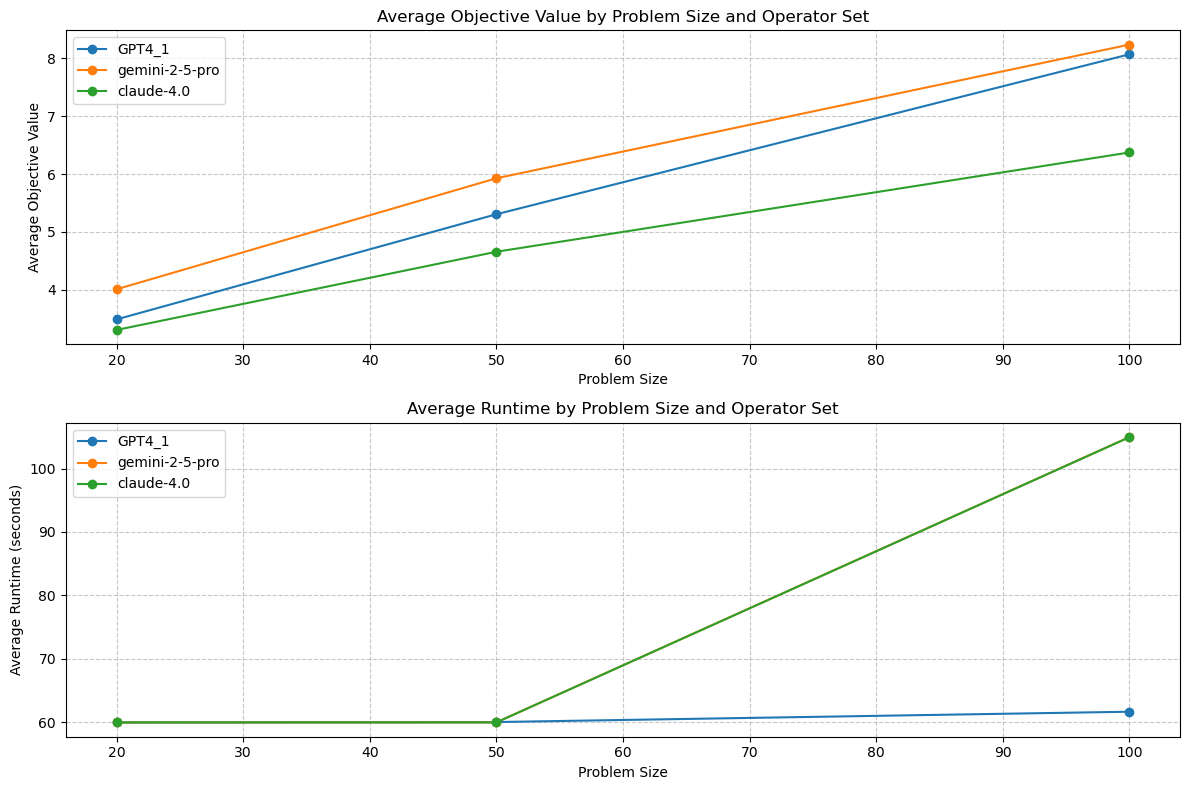

In [26]:
# Updated Main execution part
if __name__ == "__main__":
    
    # --- Run Experiments ---
    # Make sure operator_sets is defined in a previous cell
    # Adjust MAX_RUNTIME_SECONDS, PROBLEM_SIZE, N_RUNS in the configuration cell if needed
    # Run experiments for all problem sizes
    problem_sizes = [20, 50, 100]
    results_all_sizes = []

    for size in problem_sizes:
        print(f"\n{'='*50}")
        print(f"SOLVING PROBLEMS OF SIZE {size}")
        print(f"{'='*50}")
        
        # Solve all instances of this size
        results_df = solve_all_instances(
            operator_sets, 
            problem_size=size, 
            max_runtime_seconds=MAX_RUNTIME_SECONDS,
            n_runs=N_RUNS
        )
        
        if not results_df.empty:
            # Add identifier for problem size
            results_df['problem_size'] = size
            results_all_sizes.append(results_df)
        else:
            print(f"No results for problem size {size}. Check if the data file exists.")

    # Combine all results
    if results_all_sizes:
        combined_results = pd.concat(results_all_sizes, ignore_index=True)
        
        # Calculate average objective and runtime for each problem size and operator set
        summary_by_size = combined_results.groupby(['problem_size', 'operator_set']).agg(
            avg_objective=('objective_value', 'mean'),
            avg_time=('time', 'mean'),
            num_instances=('instance_id', 'nunique')
        ).reset_index()
        
        # Create a nice formatted table
        print("\n" + "="*80)
        print("SUMMARY OF RESULTS BY PROBLEM SIZE AND OPERATOR SET")
        print("="*80)
        
        # Format the summary table with better formatting
        pd.set_option('display.float_format', '{:.4f}'.format)
        print(summary_by_size)
        
        # Create visualization
        plt.figure(figsize=(12, 8))
        
        # Plot average objective values
        plt.subplot(2, 1, 1)
        for op_set in operator_sets.keys():
            subset = summary_by_size[summary_by_size['operator_set'] == op_set]
            if not subset.empty:
                plt.plot(subset['problem_size'], subset['avg_objective'], 'o-', label=op_set)
        
        plt.xlabel('Problem Size')
        plt.ylabel('Average Objective Value')
        plt.title('Average Objective Value by Problem Size and Operator Set')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        
        # Plot average runtimes
        plt.subplot(2, 1, 2)
        for op_set in operator_sets.keys():
            subset = summary_by_size[summary_by_size['operator_set'] == op_set]
            if not subset.empty:
                plt.plot(subset['problem_size'], subset['avg_time'], 'o-', label=op_set)
        
        plt.xlabel('Problem Size')
        plt.ylabel('Average Runtime (seconds)')
        plt.title('Average Runtime by Problem Size and Operator Set')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    else:
        print("No results were generated for any problem size.")

    # --- Optional: Run and plot a single instance with a specific operator set ---
    # set_to_run = 'baseline' 
    # instance_id_to_run = 1
    # if set_to_run in operator_sets and (operator_sets[set_to_run]['destroy'] and operator_sets[set_to_run]['repair']):
    #     print(f"\n--- Running single instance {instance_id_to_run} with '{set_to_run}' operators ---")
    #     single_instance = load_single_instance(problem_size=PROBLEM_SIZE, instance_id=instance_id_to_run)
    #     if single_instance:
    #          destroy_ops = operator_sets[set_to_run]['destroy']
    #          repair_ops = operator_sets[set_to_run]['repair']
    #          solution, stats = run_alns(single_instance, destroy_ops, repair_ops, max_runtime_seconds=MAX_RUNTIME_SECONDS, seed=SEED)
    #          print(f"Objective: {stats['objective_value']:.4f}, Time: {stats['time']:.4f}s")
    #          # plot_solution(solution, f"Solution with '{set_to_run}' operators (Instance {instance_id_to_run})")
    # else:
    #      print(f"\nCannot run single instance example: Operator set '{set_to_run}' not found or is empty.")
